In [1]:
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from ic_course_utils import find_highest_wf
from ic_course_utils import replace_tag

%matplotlib inline

In [2]:
input_file = "data/HEe_fullsim.buffy.h5"
#input_file = "data/HEe_fastsim.detsim.h5"
#input_file = "data/Kr83_fullsim.buffy.h5"
#input_file = "data/Kr83_fastsim.detsim.h5"

# Input file structure

The input file contains two nodes (`pmtrd` and `sipmrd`) that contain the PMT and SiPM True Waveforms (TWFs), respectively.
These are homogeneous arrays with shape (number of events, number of sensors, number of time samples).
PMTs are usually sampled much faster than SiPMs, therefore their TWFs contain much more samples, despite covering the same time span.
In this case, PMTs are sampled at 1 ns and SiPMs at 1 $\mu$s.
This translates into a waveform 1000x bigger in the PMTs than in the SiPMs.

In [3]:
!ptdump -v $input_file:/pmtrd
!ptdump -v $input_file:/sipmrd

/pmtrd (EArray(10, 12, 800000)shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 524288)
/sipmrd (EArray(10, 1792, 800)shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 327, 800)


# Input file data visualization

The module `pytables` treats these nodes equivalently to numpy arrays, so we can access them directly. The time information is not stored in the file as it is implicit, from the sampling period of the detectors (which was set in the city that generated this data (`Buffy` or `Detsim`).

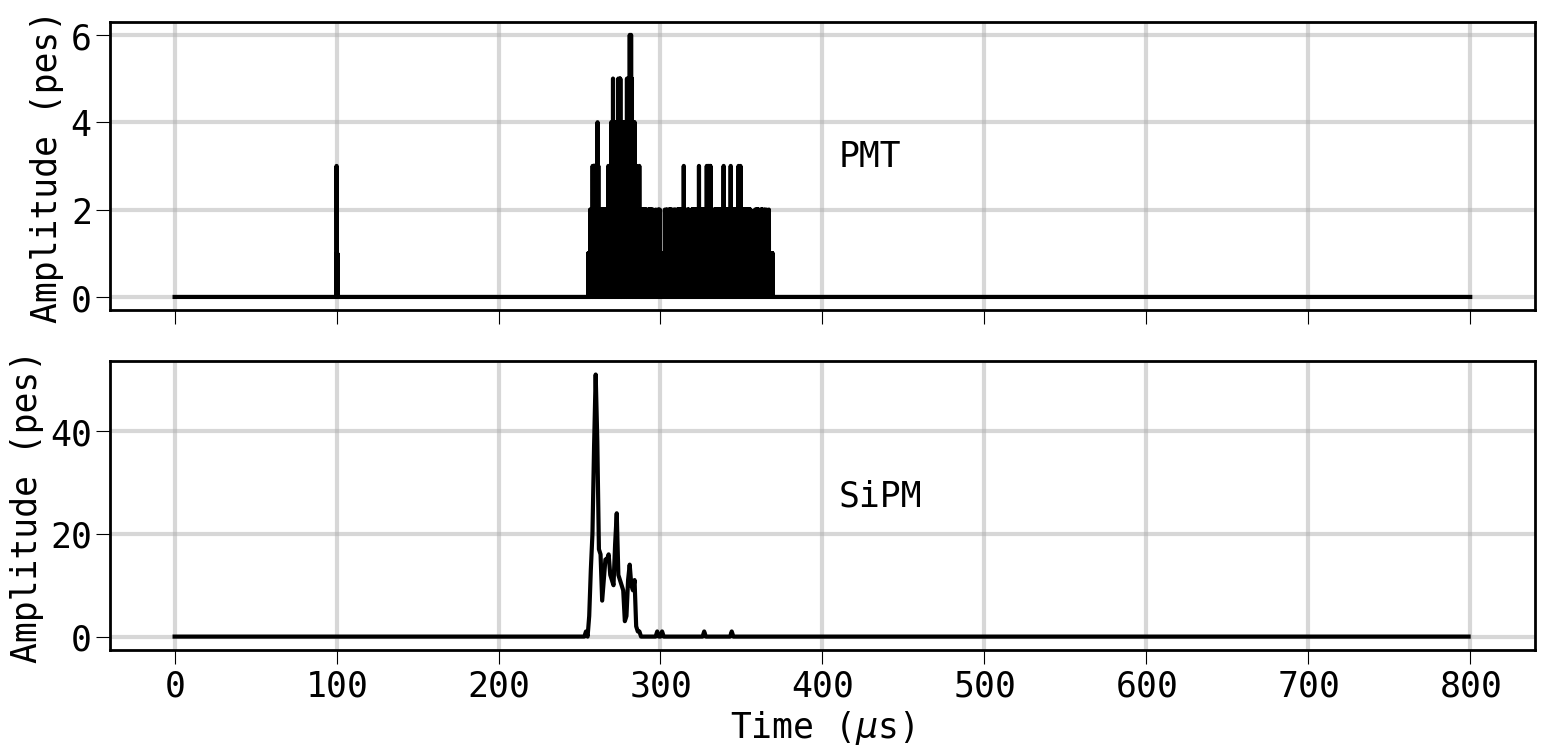

In [4]:
event_number = 1
with tb.open_file(input_file) as file:
    wf_pmt  = find_highest_wf(file.root. pmtrd, event_number)
    wf_sipm = find_highest_wf(file.root.sipmrd, event_number)

    sp_pmt  = 1e-3 # sampling period in mus
    sp_sipm = 1    # sampling period in mus
    t_pmt   = np.arange(wf_pmt .size) * sp_pmt
    t_sipm  = np.arange(wf_sipm.size) * sp_sipm

    _, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 8))
    ax1.plot(t_pmt , wf_pmt ); ax1.text(410, wf_pmt .max()/2, "PMT" );                                 ax1.set_ylabel("Amplitude (pes)")
    ax2.plot(t_sipm, wf_sipm); ax2.text(410, wf_sipm.max()/2, "SiPM"); ax2.set_xlabel("Time ($\mu$s)");ax2.set_ylabel("Amplitude (pes)")

# Diomira

## Description

Simulates the electronics of the different sensors within the detector, namely, PMTs and SiPMs, using a realistic model.

This city takes TWFs and transforms them into Raw Waveforms (RWFs), i.e. the equivalent data format produced by the detector.
The following data transformations are applied to both PMTs and SiPMs:
- Adds the sensor baseline
- Simulates the electronic noise
- Simulates gain fluctuations
- Converts (true) photoelectrons to ADC counts

For PMTs, Diomira also
- Emulates the signal-derivative effect of the energy plane electronics
- Resamples the waveforms to 25-ns waveforms to match those produced by the detector

And for SiPMs:
- Adds dark counts

Finally, the city can also emulate the trigger algorithm of the detector, but this functionality has not been used extensively and will not be covered here.
At the present time, only an S2 trigger is implemented, which processes the data in the same way as the detector and applies the same filters according to some predefined parameters.

More details in the official documentation:
(NO ENTRY FOR DIOMIRA, YET)

## Parameters

| Parameter | Type  | Description |
|:--------:|:--------:|:--------:|
| `sipm_noise_cut` | `float` | Threshold for zero-suppression |
| `filter_padding` | `int` | Number of samples to keep before/after a signal above threshold |
| `trigger_type` | `None` | Trigger type to emulate. Not covered here, use `None` |
| `trigger_params` | `dict` | Parameters for trigger configuration |
| `s2_params` | `float` | Parameters for trigger configuration |
| `random_seed` | `int` | Seed for the random number generator (\*) |


(\*) This can be helpful to ensure repeatibility or to ensure that two different runs use different random numbers

## Configuration

A typical Diomira configuration file for NEW data.

Note that here we don't specify the input and output files in the config file, but you can do so!

In [5]:
config_file = "config_files/diomira.conf"

In [6]:
!cat $config_file

compression = 'ZLIB4'
event_range = all
print_mod   = 1

run_number  = -6400
detector_db = 'new'

sipm_noise_cut = 1.0 * pes
filter_padding = 50

trigger_type = None

random_seed = 1234567890

## City execution

In [7]:
output_file = replace_tag(input_file, "buffy detsim", "diomira")
output_file

'data/HEe_fullsim.diomira.h5'

In [8]:
!city diomira $config_file -i $input_file -o $output_file

NumExpr defaulting to 4 threads.
Using selector: EpollSelector
events processed: 0, event number: 0
events processed: 1, event number: 13
events processed: 2, event number: 26
events processed: 3, event number: 39
events processed: 4, event number: 52
events processed: 5, event number: 65
events processed: 6, event number: 78
events processed: 7, event number: 91
events processed: 8, event number: 104
events processed: 9, event number: 117


## Output

Raw waveforms for PMTs and SiPMs and BiLiniear-Restored waveforms (BLRs) for the PMTs. Stored in the output file in the nodes
- `/RD/pmtrwf`
- `/RD/pmtblr`
- `/RD/sipmrwf`

These are homogeneous arrays with shape (number of events, number of sensors, number of buffer samples), where the number of buffer samples is calculated from the ratio of `length` to the sensor sampling time included in the nexus file (possibly different for PMTs and SiPMs).

In [9]:
!ptdump -v $output_file:/RD/pmtrwf
!ptdump -v $output_file:/RD/pmtblr
!ptdump -v $output_file:/RD/sipmrwf

/RD/pmtrwf (EArray(10, 12, 32000)shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 4, 32000)
/RD/pmtblr (EArray(10, 12, 32000)shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 4, 32000)
/RD/sipmrwf (EArray(10, 1792, 800)shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 327, 800)


### RWF visualization

<span class="burk">Careful with reading the entire `pmtrwf`, `pmtblr` or `sipmrd` nodes of a large file in a single go, you might run out of memory!</span>

Note that the PMT is sampled at a much higher rate than the SiPM and therefore the number of photons per sample is much lower.

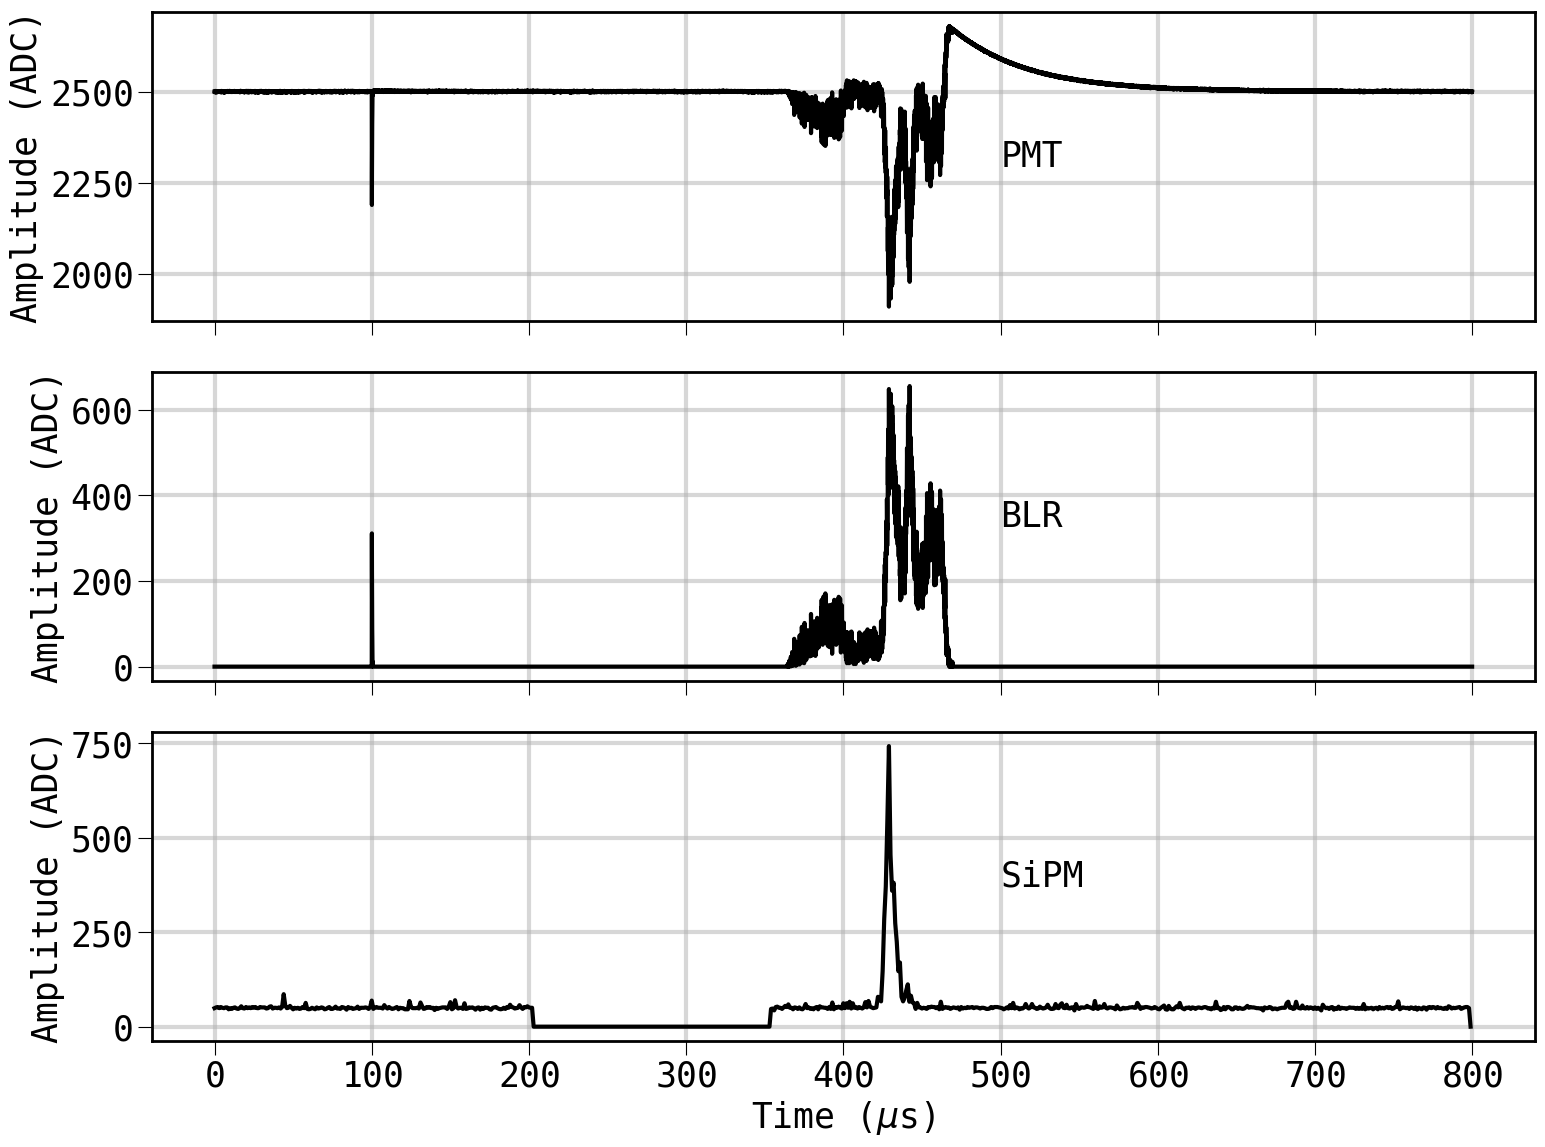

In [10]:
event_number = 9
with tb.open_file(output_file) as file:
    wf_pmt  = find_highest_wf(file.root.RD. pmtrwf, event_number)
    wf_blr  = find_highest_wf(file.root.RD. pmtblr, event_number)
    wf_sipm = find_highest_wf(file.root.RD.sipmrwf, event_number)

    sp_pmt  = 25e-3 # sampling period in mus
    sp_sipm = 1     # sampling period in mus
    t_pmt   = np.arange(wf_pmt .size) * sp_pmt
    t_sipm  = np.arange(wf_sipm.size) * sp_sipm

    _, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(16, 12))
    ax1.plot(t_pmt , wf_pmt ); ax1.text(500, (wf_pmt .max() + wf_pmt.min())/2, "PMT" );                                 ax1.set_ylabel("Amplitude (ADC)")
    ax2.plot(t_pmt , wf_blr ); ax2.text(500, wf_blr .max()                 /2, "BLR" );                                 ax2.set_ylabel("Amplitude (ADC)")
    ax3.plot(t_sipm, wf_sipm); ax3.text(500, wf_sipm.max()                 /2, "SiPM"); ax3.set_xlabel("Time ($\mu$s)");ax3.set_ylabel("Amplitude (ADC)")

Here we observe the main effects of the electronics:
- Baseline: Both PMT and SiPM waveforms have a non-null baseline
  - ~2500 ADC for PMTs
  - ~30 ADC for SiPMs
- Sampling rate: the PMT sampling rate is fixed to 25 ns (the same as the detector electronics)
- Noise: Both PMT and SiPM waveforms contain fluctuations around the baseline
- Bipolar/Unipolar signal: the PMT electronics produced bipolar signals. The BLR waveform shows what the waveform looks like after removing this effect.
- Zero suppression: The SiPM waveforms are zero-suppressed. That is, below a certain threshold, the waveform is set to 0. When the amplitude goes above the threshold, the region before and after the pulse is kept.
- The waveforms are expressed in ADC, not it photoelectrons

# Notes